In [1]:
# EXECUTE FIRST
# computational imports
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform, randint
from GPyOpt.methods import BayesianOptimization
from tpot import TPOTRegressor
from pprint import pprint

# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# display imports
from IPython.display import display, IFrame
from IPython.core.display import HTML

# import warnings
import warnings

<font size=18>Lesson 08: Hyperparameter Optimization for Machine Learning (Project)</font>

# Introduction

Fitting a model in machine learning is an optimization problem.  In a previous lesson we saw how logistic and linear regression use optimization to find the regression model coefficients to minimize difference between observed and predicted values of the response variable.

Most machine learning models also come with a bunch of parameters that need to be set which can alter the fit of the model.  For example here is the `LogisticRegression` class from scikit learn (`sklearn`):

```
class sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver=’warn’, max_iter=100, multi_class=’warn’, verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
```

Some of these parameters have to do with exactly what model is fit.  For instance, `penalty` changes the form of regularization added to the objective function to prevent overfitting while `C` changes the strength of the regularization (larger `C` is less regularization).  These extra parameters are usually called hyperparameters and to get the best model they often need to be tuned.  This tuning is another kind of optimization and is usually called "hyperparameter optimization" or "hyperparameter tuning".  This is a hot area and a little searching with Google will yield a ton of results.  <a href="https://medium.com/criteo-labs/hyper-parameter-optimization-algorithms-2fe447525903">Here is one article</a> that gives an overview of hyperparameter tuning methods (but gets a bit technical at the end).

To keep everything straight it helps to remember that model parameters and hyperparameters are different.  Hyperparameters are set or determined before the model is fit.  Model parameters are determined during the process of fitting the model to the data.

Here are four kinds of hyperparameter optimization we'll explore:

* **Grid Search:**  choose a list of possible values for each hyperparameter and loop over all the combinations of hyperparameters while fitting a model for each combination.  Return the combination that gives the best model performance.  We'll use `GridSearchCV` from the `sklearn` package.  

* **Random Search:** choose a list of possible values, or a probability distribution, for each hyperparameter.  Choose combinations at random and return the combination that gives the best model performance.  We'll use `RandomSearchCV` from the `sklearn` package.

* **Bayesian Optimization:**  after each iteration an approximate model of the objective function, called a surrogate model, is built and used to suggest a better set of hyperparameters for the next iteration.  This is really useful for objective functions that are expensive to evaluate and for which there is uncertainty or noise in the function values as there always will be when we sample data at random to feed into a machine learning model.  We'll use `BayesianSearchCV` from the `Scikit-Optimize` (skopt) package.  Other popular Python packages include `HyperOpt` and `GPyOpt`.  We aren't going to study the details of Bayesian Optimization in this class, but there are a number of tutorials on the topic.  I think <a href="http://krasserm.github.io/2018/03/21/bayesian-optimization/">this article</a> is an especially good place to start if you want to learn more about the details.  In particular, the section called "Implementation with NumPy and SciPy" walks through the process of maximize a simple $y = f(x)$.

* **Genetic Algorithms:**  a population of possible hyperparameter sets is evolved using selection, crossover, and mutation with the goal of identifying hyperparameters that yield trained models with the best performance.  We'll use the TPOT package.  We'll also see that the TPOT package is really an auto machine learning package because it can pick between multiple models using the genetic algorithm.

There are **other hyperparameter optimization approaches**, but Bayesian Optimization is currently the most popular.  Work through this presentation to get an idea of how hyperparameter optimization works!

If you haven't taken DS740 - Data Mining and Machine Learning yet, you can still follow along and do the assignment, but you might wish to revisit this assignment after you've completed DS740.  We're going to walk through the four methods of hyperparameter optimization using a problem involving regression.  Your assignment will be to apply the same methods to the classification problem of predicting loan defaults using a subset of the project data from DS705 - Statistical Methods class.  

**Note**
As of the writing of this lesson, there is an incompatibility between scikit-optimize and scikit-learn. The are compatible when you have version 0.8.1 of skopt and 0.23.2 of sklearn, though. To check your versions, run the code in the following cell. 

In [2]:
import skopt
print(skopt.__version__)
import sklearn
print(sklearn.__version__)

0.8.1
0.23.2



If you do not have version 0.8.1 of scikit-Optimize (skopt) and version 0.23.2 of scikit-learn open the "Run_This_First.term" file in this folder and run the following commands:

`pip install --user scikit-learn==0.23.2`
`pip install --user scikit-optimize==0.8.1`

You will need to restart your kernel after running these two commmands.

You should only have to do this once.


# But first... The Regression Problem

Before we try to understand hyperparameter optimization, let's first explore the data we'll be using and the type of machine learning we'll be doing. 

We'll be using a pre-processed diamonds dataset. You can read more about the <a href="https://towardsdatascience.com/predicting-diamond-prices-using-basic-measurement-metrics-bc8ba821c8f6">variables in the diamond dataset in this blog post.</a> We have used Pycaret to <a href="https://github.com/pycaret/pycaret/blob/master/tutorials/Regression%20Tutorial%20Level%20Intermediate%20-%20REG102.ipynb">pre-process the data</a> and output it as a CSV file stored in the data directory. First we'll read in the data.

In [3]:
#import the diamonds csv file
diamonds = pd.read_csv('data/diamonds_transformed.csv')
diamonds

,Cut_Fair,Cut_Good,Cut_Ideal,Cut_Signature-Ideal,Cut_Very Good,Color_D,Color_E,Color_F,Color_G,Color_H,...,Carat Weight_13.0,Carat Weight_2.0,Carat Weight_3.0,Carat Weight_4.0,Carat Weight_5.0,Carat Weight_6.0,Carat Weight_7.0,Carat Weight_8.0,Carat Weight_9.0,Price
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5169
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3470
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3183
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4370
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6250
5996,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5328
5997,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6157
5998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11206


**Our objective is to predict the target variable (Price) from the other 40 features.**

## Setup the data

In a full machine learning analysis you would want to explore the data, do feature selection and possibly feature engineering including variable rescaling. Since you are not required to know those concepts before this course, we've done that for you. We're going to focus on only hyperparameter optimization.

We've already loaded the data, but we'll grab our features, `X`, and our target variable `y`.  We could just fit a model to all of the data, but we don't want a model that's just memorized the data and can't generalize to new data (overfitting).  So we usually divide the data into test and training sets.  The training set is used to fit a model, while the test set is used to validate the result.  Typically around 20% of the data is randomly selected for the test set.  We set the random number seed in `train_test_split` for reproducibility.

In [4]:
#in x get all columns except Price column
X = diamonds.loc[:, diamonds.columns != 'Price']
#use Price column as target variable
y= diamonds['Price']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Establishing a baseline

We'll train a few different models just to get an idea of how things work and to establish a baseline.  By default these models fit the data by minimizing the mean squared error which is the average squared difference between the predicted target values and the actual target values. A closely related quantity is r-squared which is the proportion of the total variation in the target values that is captured by the predicted values.

**Our goal, for each regression model, is to maximize r-squared as measured on the test data.**

### Linear Regression and sklearn basics

This is the same multiple linear regression model you've learned about in statistics.  We saw a bit about fitting a simple linear regression model in Python as part of Lesson 4.  Fitting a model in `sklearn` is pretty straightforward.

In [5]:
# Create a model object (hyperparameters would be declared here, but we are using default values) 
model_lr = LinearRegression()

# Fit the model by calling its fit() method
model_lr.fit(X_train, y_train)

LinearRegression()

In a basic machine learning pipeline we could look at the model score.  This is basically the objective function value being optimized by sci-kit (or a quantity derived from that).  For regression models we usually look at either
* mean squared error: the average squared difference between the true and predicted target values 
or
* r-squared: the proportion of the total variation in the target values that is accounted for by the model

### Mathematical representation of $R^2$ and MSE:

Definitions:
* $y_{i}$ = actual i*th* observation
* $f_{i}$ = predicted i*th* observation
* $\bar{y}$ = mean of actual observations
* $n$ = degrees of freedom (or num observations)

**Total sum of squares** (proportional to the variance of the data):

$ SS_{total} = \displaystyle \sum_{i} (y_{i} - \bar{y})^2$

**Residuals sum of squares** , also called sum of squares residuals:

$ SS_{res} = \displaystyle \sum_{i} (y_{i} - f_{i})^2$

**Mean squared error**:

MSE = $SS_{res}\over n $

#### The most general definition of the coefficient of determination is:

$ R^2 = 1 - {SS_{res}\over SS_{tot}}$

For regression, if we compute the score of the model applied to the training data:

In [6]:
score_training = model_lr.score(X_train,y_train)
print(f"Model r-squared score from training data {score_training:.4f}")

Model r-squared score from training data 0.8731


This value of r-squared is the same as the value you met in statistics.  We interpret this to mean that our linear regression model captures 87.3% of the variation in the training data.  However, in a machine learning context we want to know how this model works on new data.  

If we apply the score() method to the test data it's no longer the value of r-squared that we learned about in a statistics class.  *This is because we are evaluating r-squared score on data that was not used to build the model.* For example, we can get a negative r-squared number which indicates that the model is performing worse, on the test data, than simply predicting that all of the target values are the same as the average target value.  

In short, when we compute the r-squared score() for the test data, values near one are great.  Values near zero just mean the model isn't really helping and negative values mean that are model is worse than no model at all.  This is the metric we will use to select our regression models so **bigger is better**.  Here is how we compute it:

In [7]:
# Step 4 - assess model quality on test data
score_test = model_lr.score(X_test,y_test)
print(f"Model r-squared score from test data: {score_test:.4f}")

Model r-squared score from test data: 0.8742


This number doesn't have the same clean interpretation as r-squared in a statistics setting, but it is useful for comparing models if we remember larger scores are better.  (Note:  if we were looking at mean square instead, then smaller would be better.)

Finally we can use our model to make predictions:

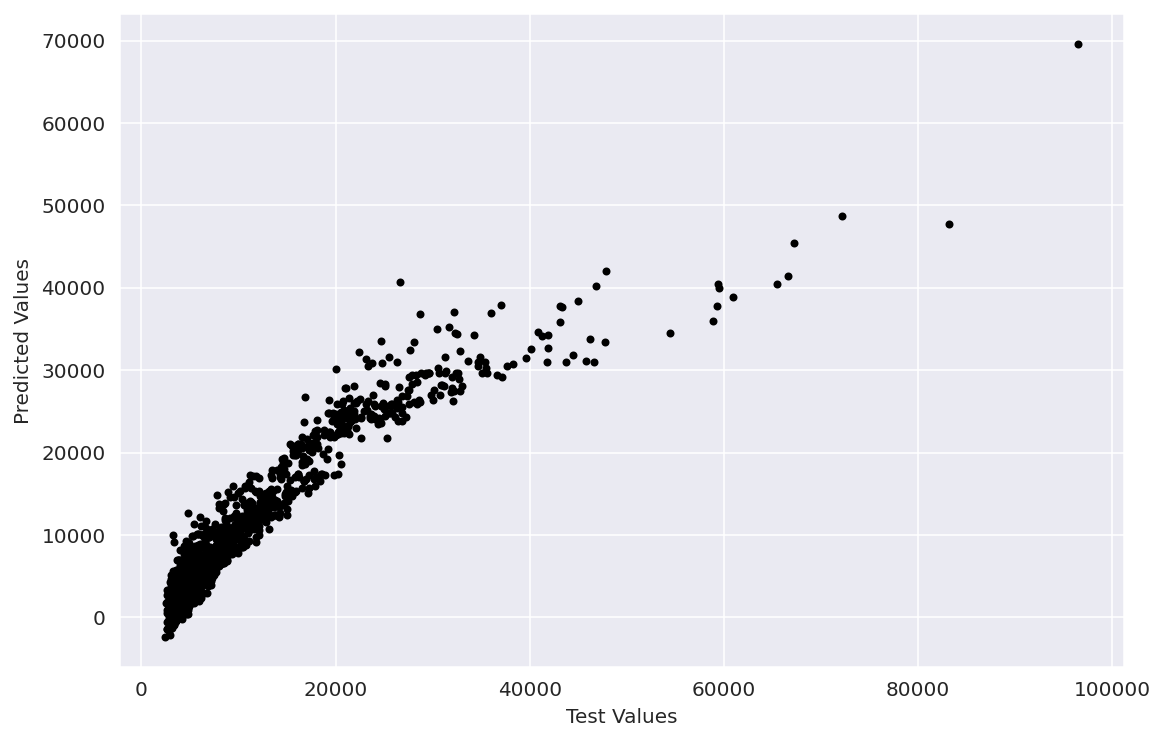

In [8]:
# Make predictions
y_pred = model_lr.predict(X_test)

# The plot is optional, but it gives an idea of the model accuracy, 
# in a perfect model the points would line up along the diagonal (y=x)
# import matplotlib.pyplot as plt
plt.figure(figsize=(9,6))
plt.plot(y_test,y_pred,'k.')
plt.xlabel('Test Values')
plt.ylabel('Predicted Values');

From the plot we can see that the model is far from perfect, but it is getting the overall trend right.  One thing to note is that it's doing a pretty poor job at predicting large target values.  

For a real-world problem we'd want to assess the accuracy of the model predictions on the test data.  For regression problems this is often done with the mean square error or root mean square error (rmse):

In [9]:
# Assess accuracy on test-data.

# from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
print(f"Mean squared error on test data: {mse:.2f}")
print(f"Root mean squared error on test data: {rmse:.2f}")

Mean squared error on test data: 13563408.00
Root mean squared error on test data: 3682.85


You can interpret the rmse to roughly mean that the average error in our predictions is about \$3682.  Below we condense the code into one cell to make it easier to follow.

Model r-squared score from test data: 0.8742


Mean squared error on test data: 13563408.00
Root mean squared error on test data: 3682.85


3682.85

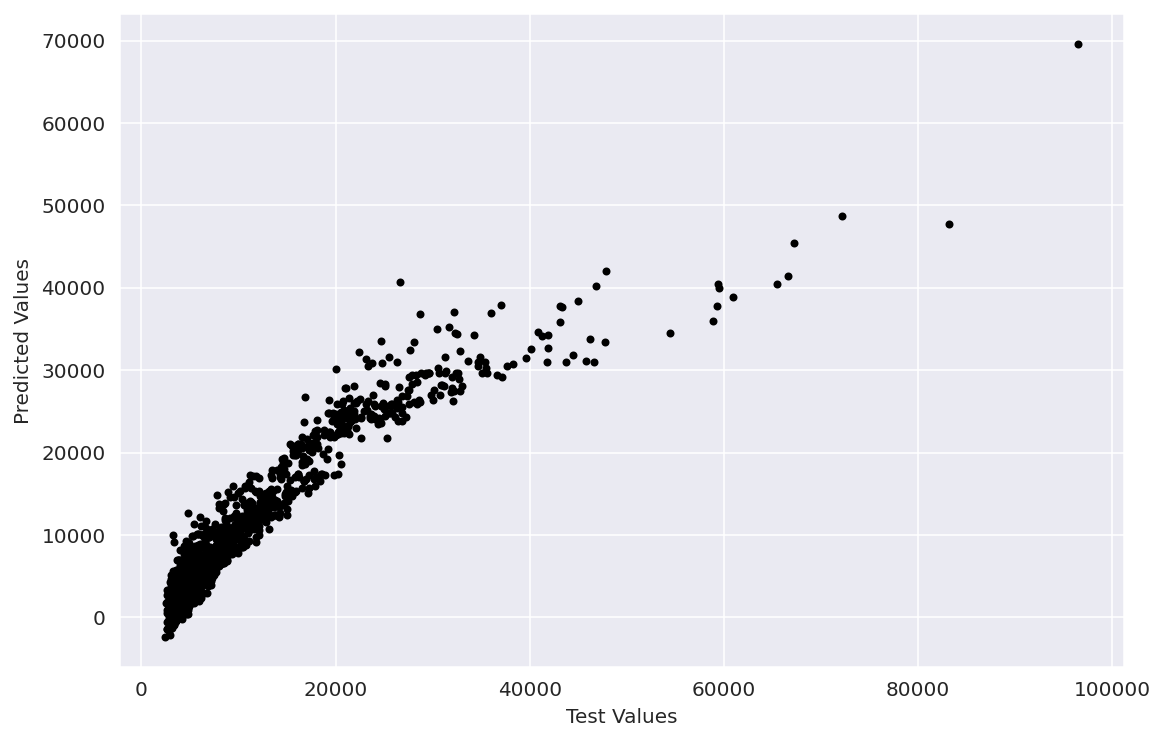

In [10]:
# Here is all the code in one cell with most of it wrapped into a function for reuse

# from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train,y_train) # this could be inside the function below too

def my_regression_results(model):
    score_test = model.score(X_test,y_test)
    print('Model r-squared score from test data: {:0.4f}'.format(score_test))

    y_pred = model.predict(X_test)
    # import matplotlib.pyplot as plt
    plt.figure(figsize=(9,6))
    plt.plot(y_test,y_pred,'k.')
    plt.xlabel('Test Values')
    plt.ylabel('Predicted Values');

    # from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    print('Mean squared error on test data: {:0.2f}'.format(mse))
    print('Root mean squared error on test data: {:0.2f}'.format(rmse))
    return (round(rmse, 2))
    
my_regression_results(model_lr)

Now it's very easy to assess other models by first creating a model object in sklearn and then using our custom function `my_regression_results`. 


### Random Forest Regression

Random Forest regression uses an ensemble of decision trees and combines their final output to build a predictive model. If you haven't taken DS740 yet, that's OK.  All we really need to know is that a Random Forest regressor is a predictive model with a bunch of hyperparameters that can be changed and often are very influential in the model performance.  These models are computationally expensive to train because a typical ensemble uses 10 to 100 or more decision trees.

Model r-squared score from test data: 0.9674


Mean squared error on test data: 3517749.65
Root mean squared error on test data: 1875.57


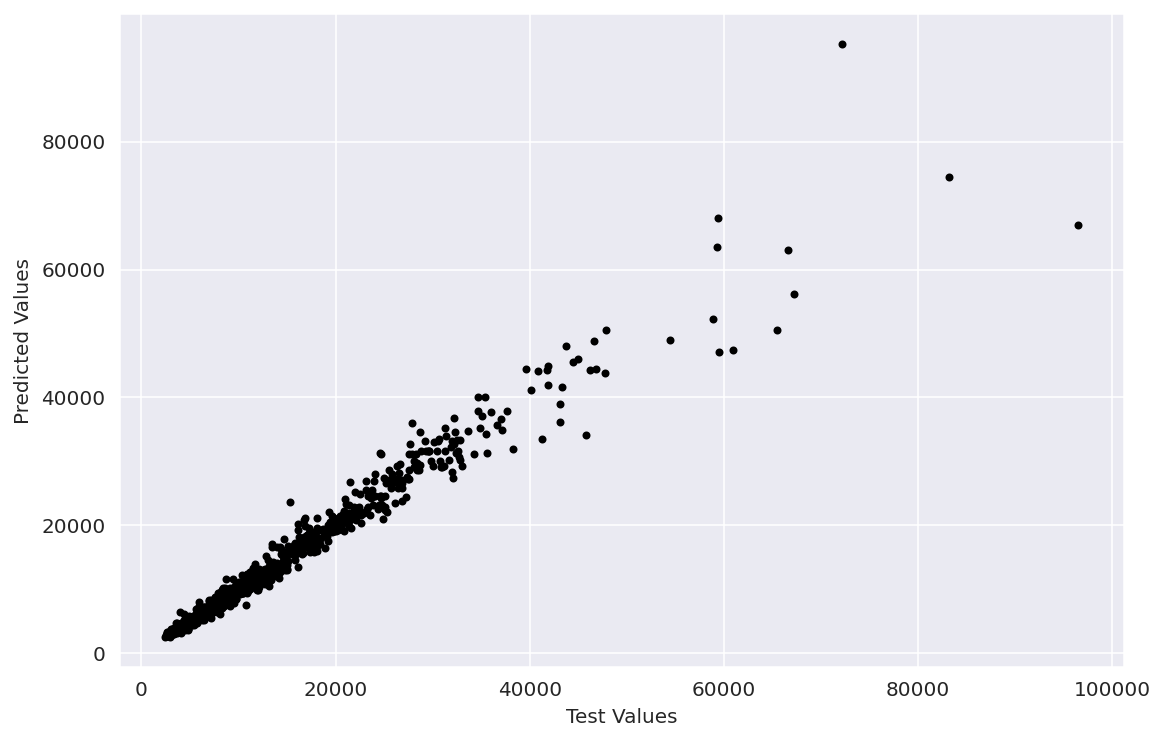

In [11]:
# from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train,y_train)

rf_rmse = my_regression_results(rf_model)

The random forest model, with default parameters, is much better than the linear regression model.

### XGBoost

XGBoost is a decision-tree-based ensemble algorithm that uses a gradient boosting framework to produce some pretty fantastic results.  We won't go into the details, but <a href="https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d">this article</a> has a pretty nice description and talks about a variety of decision-tree based algorithms.  XGBoost is typically quite a bit faster to train than a random forest algorithm, but can still be computationally expensive.

Model r-squared score from test data: 0.9690
Mean squared error on test data: 3347681.78
Root mean squared error on test data: 1829.67


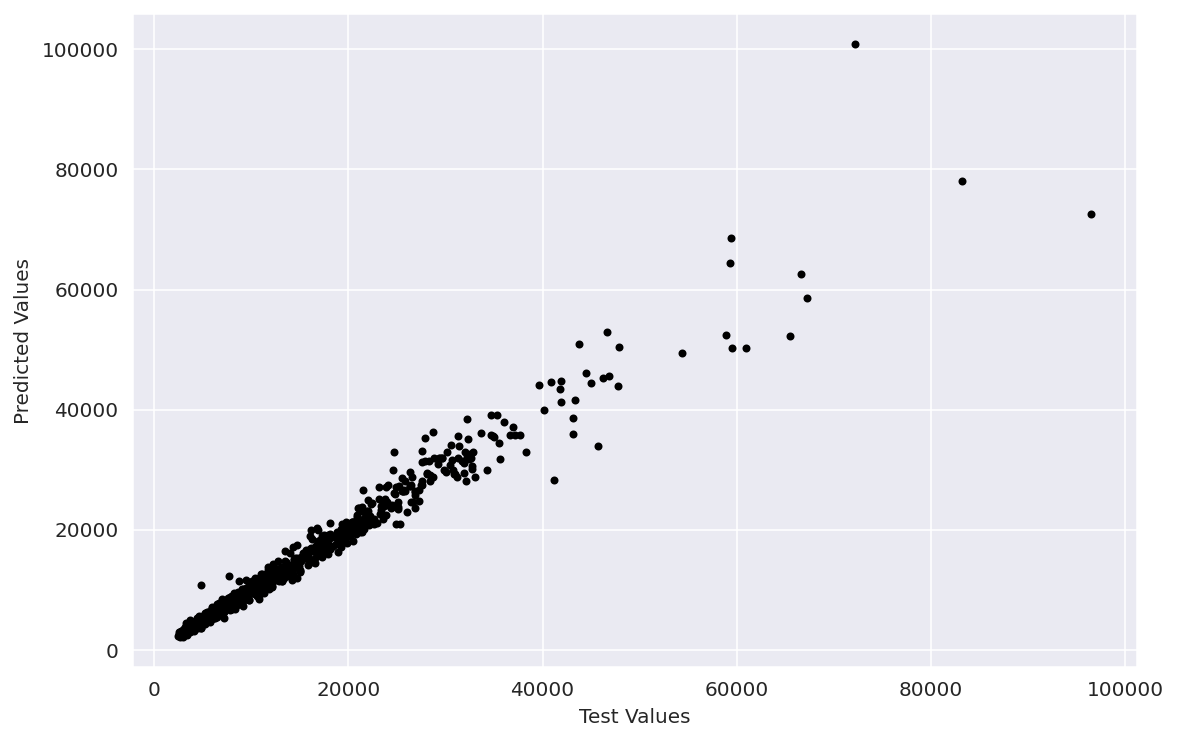

In [12]:
# import xgboost as xgb

xgbr_model = xgb.XGBRegressor(objective ='reg:squarederror')
xgbr_model.fit(X_train,y_train)

xg_default_rmse = my_regression_results(xgbr_model)

Depending on what random seeds and such you're using, you may find that xgboost does better or worse than some of the other models.

Our best model thus far with the seed we set is the XGBoost model.  Perhaps using the default hyperparameter values for training the other models wasn't the best choice.  In what follows, we'll try to improve the xgboost model by tuning its parameters.

# Estimating the model score without test data

We'd like to optimize the scores of our models when applied to data the model hasn't seen. However, the model doesn't see the test data during model training.  To estimate the test data model score we apply k-fold cross validation to the model training process.

This technique is taught in DS740 and you can learn more in <a href="https://machinelearningmastery.com/k-fold-cross-validation/">this article</a>.  Basically the training data is divided into k subsets and the subsets are used to build models.  The scores from these models are averaged to estimate the score when applied to unseen data.  Cross validation is used by all of our hyperparameter optimization algorithms to estimate the model score and this estimated score is what we try to optimize.  

We won't really have to do cross-validation directly, but this bit of code shows how we could do it using `sklearn`.  Here we are estimating the test error of our xgboost model using 3-fold cross-validation (3 is the default number of folds for `cross_val_score`, but 5 is more commonly used for hyperparameter optimization):

In [13]:
# from sklearn.model_selection import cross_val_score, KFold
scores = cross_val_score(xgbr_model, X=X_train, y=y_train, cv = 3)
print(f"The average score across the folds is {scores.mean():.4f}")

The average score across the folds is 0.9718


**Here is the important bit about cross-validation** for estimating model performance:  *the k-fold cross-validated model score is the quantity we optimize in hyperparameter optimization*.

For regression problems we are usually minimizing the k-fold cross-validated mean square error.  For classification problems we maximize the k-fold cross-validated accuracy where accuracy is the total number of correct classifications divided by the total number of classifications.  The number of folds used is commonly $k=5$ or $k=10$, but we'll mostly use $k=3$ just to speed things up for learning purposes.

# Hyperparameter Optimization applied to XGBoost Regression

We'll focus on the XGboost model for regression because it's a pretty amazing model.  If you haven't heard about it, then try to Google a bit or <a href="https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/">check out this article</a> to learn more.  The XGboost model has many hyperparameters:

In [14]:
# from pprint import pprint
pprint(xgbr_model.get_xgb_params())

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}


Fortunately the default values shown above work pretty well in many problems.  Some of the hyperparameters don't directly change the model like `nthread` and `verbosity`.  Of the rest we'll pick a subset to optimize.  Some commonly optimized parameters are `n_estimators`, `max_depth`, `learning_rate`, `subsample`, and `min_child_weight` (these are the same ones that are optimized in the `TPOT` package). Two other hyperparameters linked to regularization terms are `reg_lambda` and `reg_alpha` which can be useful to prevent overfitting.

The table below lists some typical values and default values:

Hyperparameter | Default Value | Typical Range
---- | ---- | ----
n_estimators | 100 | 10 to 150
max_depth | 3 | 1 to 10
min_child_weight | 1 | 1 to 20
learning_rate | 0.1 | 0.001 to 1
subsample | 1 | 0.05 to 1
reg_lambda | 1 | 0 to 5
reg_alpha  | 0 | 0 to 5

Of course, we could throw more hyperparameters into the mix, but we'll keep the numbers down to so we can afford to experiment.  


## Using GridSearchCV

The idea behind grid search is to pick a list of potential values for each hyperparameter and then search all the possible combinations doing a k-fold cross validation for each combination.  That means we have to do k * number of combinations model fits.  If we were to run this code

```
params = {
    "learning_rate": [0.001, 0.01, 0.1, 0.5, 1.],
    "max_depth": np.arange(1,11),
    "n_estimators": [10,50,100,150],
    "subsample": np.arange(0.05,1.01,0.05),
    "min_child_weight": np.arange(1,21),
    "reg_lambda": np.arange(0,5.5,0.5),
    "reg_alpha": np.arange(0,5.5,0.5)
    
}

grid_search = GridSearchCV(xgb_model, param_grid=params, cv=5, verbose=1, return_train_score=True)

grid_search.fit(X_train,y_train)
```

we have $k=5$ and $5 \times 10 \times 4 \times 20 \times 20 \times 10 \times 10 = 8,000,000$ combinations for a total of 40,000,000 model fits. Even if we could fit 10 models per second, it would still take about 46 days to try all the models.  Nevertheless, GridSearchCV is commonly used by trimming the number of possible values for each parameter to get something manageable.

As you can see the lists or arrays of values for the hyperparameters are stored in a dictionary.  The number of cross-validation folds is set by `cv = 5`.

To illustrate how this works we'll pick fewer values for each hyperparameter as shown in the next cell, but we are still doing $2^6 \times 3 \times 5 = 960$ model fits which takes several minutes to run on our computers.

In [15]:
# run GridSearchCV with our xgbr_model to find better hyperparameters
# from sklearn.model_selection import GridSearchCV

# define the grid
params = {
    "learning_rate": [0.01, 0.1],
    "max_depth": [2, 4, 6],
    "n_estimators": [100,150],
    "subsample": [0.8, 1],
    "min_child_weight": [1, 3],
    "reg_lambda": [1, 3],
    "reg_alpha": [1, 3]
}

# setup the grid search
grid_search = GridSearchCV(xgbr_model,
                           param_grid=params,
                           cv=5,
                           verbose=1,
                           n_jobs=1,
                           return_train_score=True)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed: 63.7min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=0,
                                    num_parallel_tree=1, random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
      

The best hyperparameter values are stored in the grid_search object as a dictionary:

In [69]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 150,
 'reg_alpha': 3,
 'reg_lambda': 3,
 'subsample': 0.8}

Several of the values are different than their default values.  To see if this optimized model is better than the default XGBoost model let's apply it to the test data:


Model r-squared score from test data: 0.9732
Mean squared error on test data: 2890902.73
Root mean squared error on test data: 1700.27


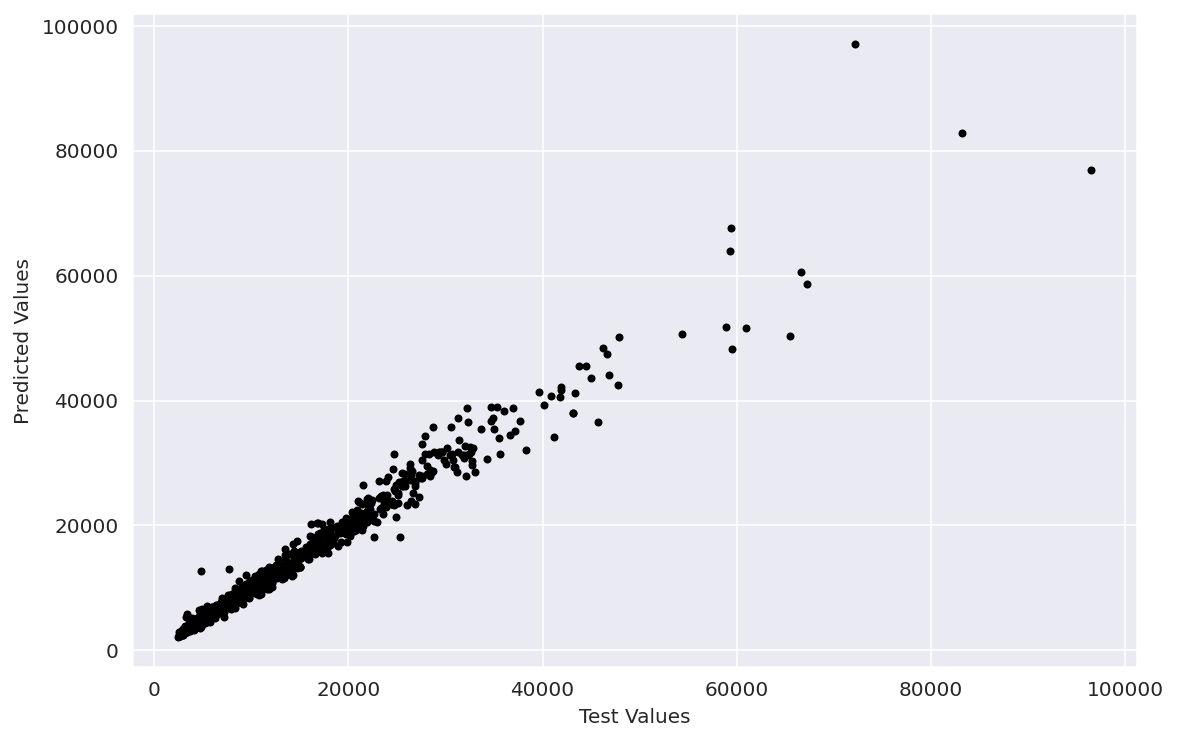

In [70]:
gs_rmse = my_regression_results(grid_search)

This is a nice improvement over the default XGBoost regression model.  Our tuned model now performs better than the linear regression model we saw above.

The main drawback to grid search is that it can get really expensive if we want to exhaustively search, particularly if the model fits are slow as they can be when large datasets with many predictors are used.

Before we get too far, let's create a way to track our results. In the next cell, we have a function that will track the approach we're using, the best hyperparameters, and the RMSE. Note that we call it twice - once to enter the data from our default XGBoost model, and once to add the results from our grid search approach. Note that we use show=False the first time, so that we only output a single dataframe of results. We return our current dictionary of results, which we can use each successive time we call the function.

In [71]:
#a function to track the results of our different hyperparameter optimization approaches
def track_results(approachName, params, rmse, fits, current, show=True):
    current['Approach'].append(approachName)
    current['RMSE'].append(rmse)
    current['Fits'].append(fits)
    for k in params.keys():
        current[k].append(params[k])
    if show:
        df = pd.DataFrame(current)
        df = df.sort_values('RMSE', ascending=True)
        display(df)
    return current    
setup = {'Approach': [],
         'learning_rate': [],
         'max_depth': [],
         'min_child_weight': [],
         'n_estimators': [],
         'reg_alpha': [],
         'reg_lambda': [],
         'subsample': [],
         'Fits': [],
         'RMSE': []
        } 

defaults = {
    'learning_rate': .1,
         'max_depth': 3,
         'min_child_weight': 1,
         'n_estimators': 100,
         'reg_alpha': 0,
         'reg_lambda': 1,
         'subsample': 1,
}

current = track_results('Default XGBoost', defaults, 1829.67, 1, setup, False  )
current = track_results('Grid Search', grid_search.best_params_, 1700.27,960, current, True )    

,Approach,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,Fits,RMSE
1,Grid Search,0.1,6,1,150,3,3,0.8,960,1700.27
0,Default XGBoost,0.1,3,1,100,0,1,1.0,1,1829.67


## Using RandomizedSearchCV

If we can only afford to fit the model a limited number of times, then one approach is to search randomly instead of exhaustively.  To use `RandomizedSearchCV` we can either specify a probability distribution for each hyperparameter or we can specify a list of values for the hyperparameter in which case a value is chosen from the list assuming all values in the list are equally probable. 

For optimizing our XGBoost model Wwe'll leave the learning rate as a list since we want more small values to choose from than large values.  The other hyperparameters can be specified with distributions.  Note that the uniform distribution specified below is not intuitive.  `uniform(loc,scale)` is uniform on the interval `[loc, loc+scale]`.  For the search below we're going to check just 25 randomly selected sets of hyperparameters as we might for a really expensive model.   `random_state = 8675309` is a random number seed for reproducibility.  Change it and you'll get different results.  

In [72]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import uniform, randint

params = {
    "learning_rate": [0.001, 0.01, 0.1, 0.5, 1.],
    "max_depth": randint(1, 10),
    "n_estimators": randint(10, 150),
    "subsample": uniform(0.05, 0.95),  # so uniform on [.05,.05+.95] = [.05,1.]
    "min_child_weight": randint(1, 20),
    "reg_alpha": uniform(0, 5),
    "reg_lambda": uniform(0, 5)
}

random_search = RandomizedSearchCV(
    xgbr_model,
    param_distributions=params,
    random_state=8675309,
    n_iter=25,
    cv=5,
    verbose=1,
    n_jobs=1,
    return_train_score=True)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  1.6min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=0,
                                          num_par...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4e73371250>,
                   

The best hyperparameters found:

In [73]:
random_search.best_params_

{'learning_rate': 0.5,
 'max_depth': 8,
 'min_child_weight': 13,
 'n_estimators': 54,
 'reg_alpha': 4.273531344366107,
 'reg_lambda': 0.3614847715291919,
 'subsample': 0.9827539273587139}

Model r-squared score from test data: 0.9676
Mean squared error on test data: 3497319.70
Root mean squared error on test data: 1870.11


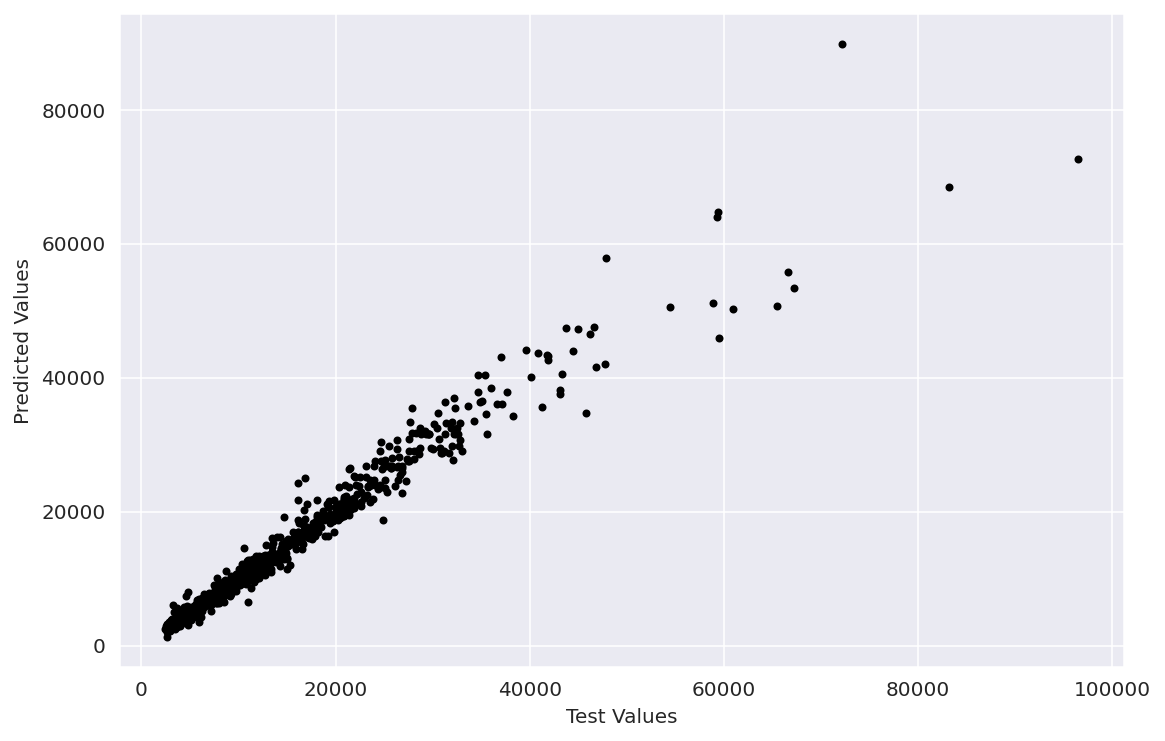

In [74]:
my_regression_results(random_search)

In [75]:
#track current results
current = track_results('Random Search', random_search.best_params_, 1870.11,125, current, True )    

,Approach,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,Fits,RMSE
1,Grid Search,0.1,6,1,150,3.000000,3.000000,0.800000,960,1700.27
0,Default XGBoost,0.1,3,1,100,0.000000,1.000000,1.000000,1,1829.67
2,Random Search,0.5,8,13,54,4.273531,0.361485,0.982754,125,1870.11


The random search in this case did not find a very good fit. Note that it did not choose any of the default parameters. The default parameters outperformed those chosen by the random search.

# Bayesian Optimization with Scikit-Optimize

<a href="https://scikit-optimize.github.io/stable/">Scikit-Optimize</a> is an optimization package built on top of scikit-learn. It allows you to tune your hyperparameters using Bayesian optimization, as well as do some visualization of your optimization results.



On average Bayesian optimization does better than random search.  It especially excels when there are lots of hyperparameters, but it won't beat random search every time.  The power of Bayesian optimization is that it can often achieve good results with a relatively short number of training iterations.  

The setup is a quite similar to random search, with just slight differences in how we set up our parameters, called <a href="https://scikit-optimize.github.io/stable/modules/generated/skopt.Optimizer.html">dimensions</a> in the documentation. 
* for lists of values, we need to wrap the list in the Categorical() function
* when we want a range of integers optimized, we just pass the low and high values
* when we want a range of real numbers, we pass the low and high, making sure to use floats or wrap it in REAL()
* when we know the distribution, we can pass the name of the distribution, along with the low and high (the default is uniform)


In [76]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


#this is what we used for random and grid search
# params = {
#     "learning_rate": [0.001, 0.01, 0.1, 0.5, 1.],
#     "max_depth": randint(1, 10),
#     "n_estimators": randint(10, 150),
#     "subsample": uniform(0.05, 0.95),  # so uniform on [.05,.05+.95] = [.05,1.]
#     "min_child_weight": randint(1, 20),
#     "reg_alpha": uniform(0, 5),
#     "reg_lambda": uniform(0, 5)
# }

params = {
    "learning_rate": Categorical([0.001, 0.01, 0.1, 0.5, 1.]), #use categorical here
    "max_depth": (1, 10), #this will optimize all integers 1-10 with equal probability
    "n_estimators": (10, 150),
    "subsample": (0.05, .95),
    "min_child_weight": (1, 20),
    "reg_alpha": (0, 5, 'uniform'),
    "reg_lambda": (0, 5, 'uniform')
}

bayes_search = BayesSearchCV(
    xgbr_model,   
    search_spaces=params,
    random_state=8675309,
    n_iter=25,
    cv=5,
    verbose=1,
    n_jobs=1,
    return_train_score=True)


bayes_search.fit(X_train, y_train)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel...
                                     tree_method='exact', validate_parameters=1,
                                     verbosity=None),
              n_iter=25, random_state=8675309, return_train_score=True,
              search_spaces={'learnin

In [77]:
print('Total iterations:', bayes_search.total_iterations)
bayes_search.best_params_

Total iterations: 175


OrderedDict([('learning_rate', 0.1),
             ('max_depth', 10),
             ('min_child_weight', 1),
             ('n_estimators', 150),
             ('reg_alpha', 5),
             ('reg_lambda', 5),
             ('subsample', 0.3348985764419966)])

Model r-squared score from test data: 0.9744
Mean squared error on test data: 2758555.08
Root mean squared error on test data: 1660.89


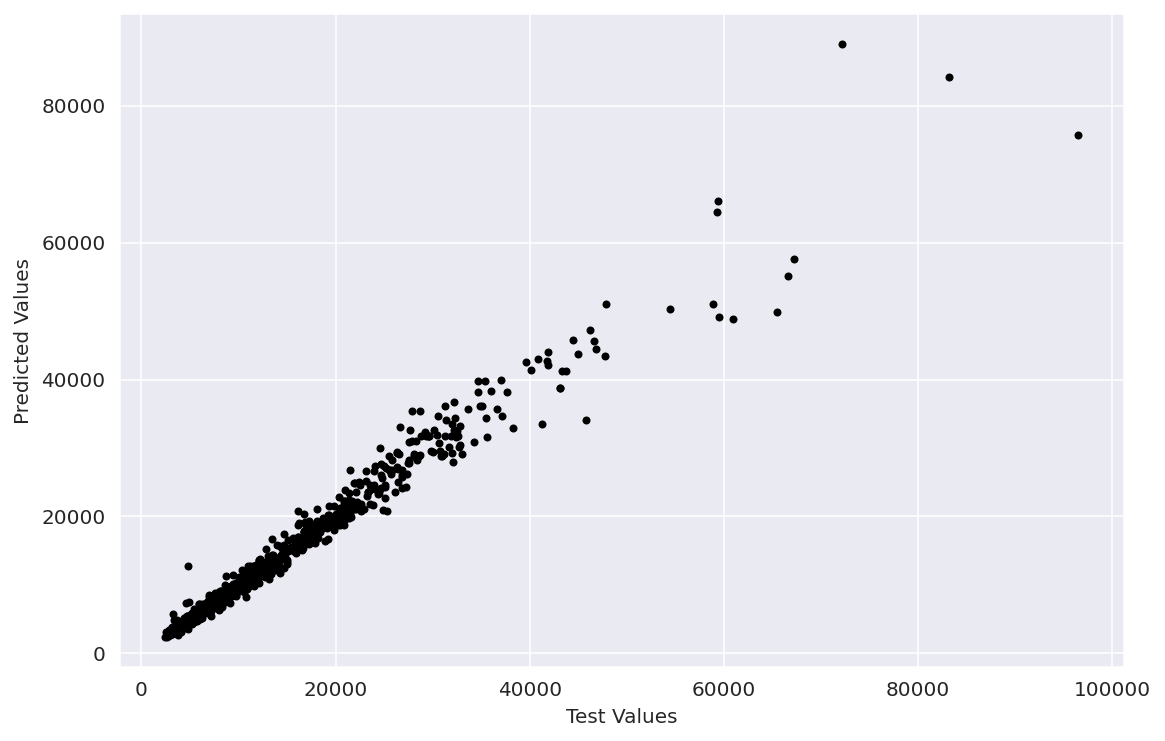

In [78]:
my_regression_results(bayes_search)

In [79]:
#track current results
current = track_results('Bayes Search', bayes_search.best_params_, 1660.89,175, current, True )    

,Approach,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,Fits,RMSE
3,Bayes Search,0.1,10,1,150,5.000000,5.000000,0.334899,175,1660.89
1,Grid Search,0.1,6,1,150,3.000000,3.000000,0.800000,960,1700.27
0,Default XGBoost,0.1,3,1,100,0.000000,1.000000,1.000000,1,1829.67
2,Random Search,0.5,8,13,54,4.273531,0.361485,0.982754,125,1870.11


Depending on the random seeds you've used you might see that Bayesian Optimization does better or worse than other methods.  (Try a few different seeds and compare.)  For the particular seed that we set, Bayes outshined grid search, and used far fewer fits (175 vs 960).

Both random search and Bayesian optimization will give better results if they're allowed to run for more iterations.  Bayesian optimization doesn't always beat random or grid search, but common wisdom suggests that it usually works better - see this <a href="https://stats.stackexchange.com/questions/302891/hyper-parameters-tuning-random-search-vs-bayesian-optimization">Stack Exchange post</a> for some nice discussion and references.  Moreover companies are getting into automatic machine learning in a big way and some of the giants, <a href="https://cloud.google.com/blog/products/gcp/hyperparameter-tuning-cloud-machine-learning-engine-using-bayesian-optimization">like Google, are betting on Bayesian Optimization</a>.  

## Using a Genetic Algorithm from TPOT

We really don't need to do much with genetic algorithms to use TPOT, though we can change the usual parameters like population size, mutation probability, and crossover probability.  The software authors recommend leaving the probabilities at their default values - <a href="https://epistasislab.github.io/tpot/"> the documentation is here.</a> 

TPOT can actually do much more than optimize hyperparameters for a single model, but it can do that too.  To focus on a single model we set up a nested dictionary like that shown in the code below.    Then we call TPOT and it returns an optimized model in an object that behaves just like objects returned by GridSearchCV and RandomSearchCV.  Additional models could be added as `'model_name':{'param':values,'param':value,...}`.

We've found that we generally need more model fits to get good results with TPOT than we did with Bayesian Optimization, but it still works really well.  Note that TPOT is maximizing the k-fold cross-validated negative mean square error instead of r-squared, but it gets us to the same place.  Here we iterate for 10 generations with 10 different individual sets of hyperameters in each generation.  For each individual we do 3 model fits (k = 3) and there is an extra round of cross validated fits for the initial population, thus altogether we perform $4 \times 10 \times 10 = 400$ model fits.

In [80]:
from tpot import TPOTRegressor

tpot_config = {
    'xgboost.XGBRegressor': {
        'n_estimators': [100],
        'max_depth': range(1, 11),
        'learning_rate': np.append(np.array([.001,.01]),np.arange(0.05,1.05,.05)),
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'reg_alpha': np.arange(1.0,5.25,.25),
        'reg_lambda': np.arange(1.0,5.25,.25),
        'nthread': [1],
        'objective': ['reg:squarederror']
    }
}

tpot = TPOTRegressor(scoring = 'r2',
                     generations=10,
                     population_size=10,
                     verbosity=2,
                     config_dict=tpot_config,
                     cv=3,
                     template='Regressor', #no stacked models
                     random_state=8675309)

tpot.fit(X_train, y_train)
tpot.export('tpot_XGBregressor.py') # export the model

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9669359796971312



Generation 2 - Current best internal CV score: 0.9739527739793802



Generation 3 - Current best internal CV score: 0.9739527739793802



Generation 4 - Current best internal CV score: 0.9739527739793802



Generation 5 - Current best internal CV score: 0.9739527739793802



Generation 6 - Current best internal CV score: 0.9740139708348456



Generation 7 - Current best internal CV score: 0.9740139708348456



Generation 8 - Current best internal CV score: 0.974643870779841



Generation 9 - Current best internal CV score: 0.974643870779841



Generation 10 - Current best internal CV score: 0.974643870779841



Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=100, nthread=1, objective=reg:squarederror, reg_alpha=3.25, reg_lambda=4.0, subsample=0.7500000000000001)


One nice feature of TPOT is that it can write the optimized model to a file which you can use elsewhere.

We can display the results on the test data in the same way as with our other models.

Model r-squared score from test data: 0.9726
Mean squared error on test data: 2958126.24
Root mean squared error on test data: 1719.92


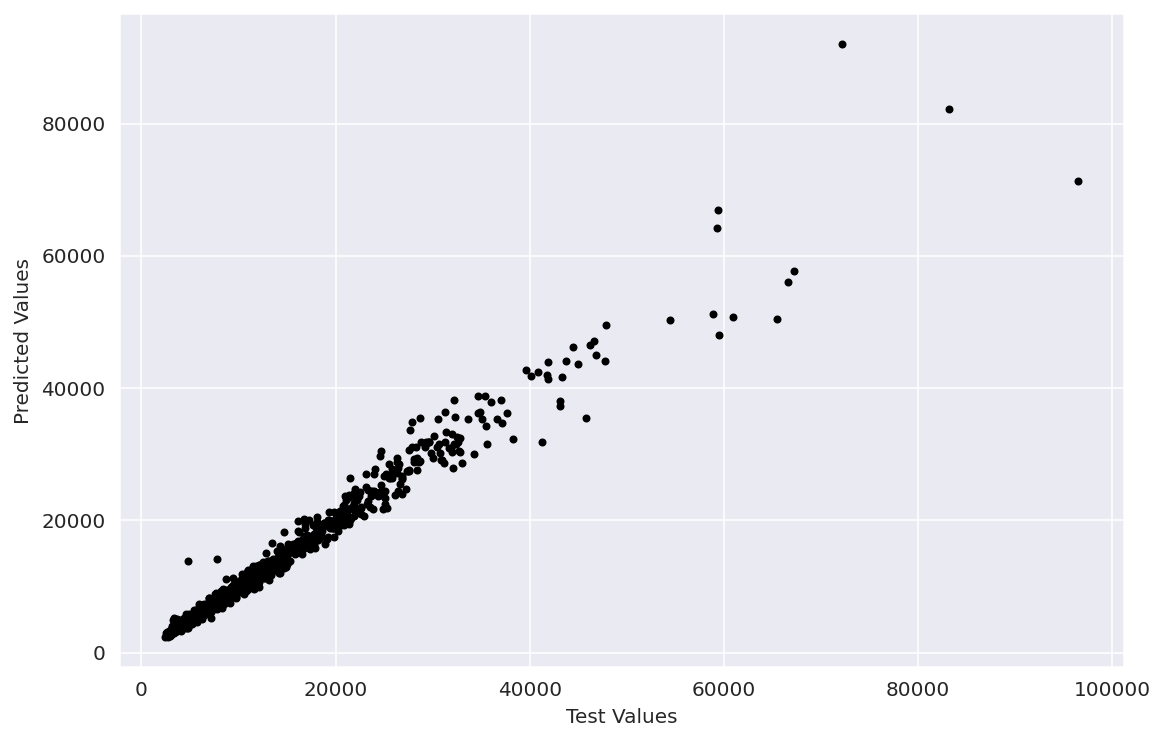

In [81]:
my_regression_results(tpot)

To track our best parameters, you'll need to make a dictionary based on the "Best pipeline" printed out from tpot. Unfortunately, we have not found a way to capture this programmatically. But it's pretty easy to cut and paste.

In [82]:
tpot_best_params = {'learning_rate':0.1, 'max_depth':8, 'min_child_weight':1, 'n_estimators':100,   'reg_alpha':3.25, 'reg_lambda':4.0, 'subsample':0.7500000000000001}

current = track_results('TPOT', tpot_best_params, 1719.92,400, current, True )    

,Approach,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,Fits,RMSE
3,Bayes Search,0.1,10,1,150,5.000000,5.000000,0.334899,175,1660.89
1,Grid Search,0.1,6,1,150,3.000000,3.000000,0.800000,960,1700.27
4,TPOT,0.1,8,1,100,3.250000,4.000000,0.750000,400,1719.92
0,Default XGBoost,0.1,3,1,100,0.000000,1.000000,1.000000,1,1829.67
2,Random Search,0.5,8,13,54,4.273531,0.361485,0.982754,125,1870.11


In this example TPOT did slightly worse than `BayesianOptimization` and `Grid Search`, but TPOT can do much more as we'll see in the next section.

## AutoML with TPOT

We've actually used TPOT in a rather narrow way by forcing it to optimize the hyperparameters for one choice of a machine learning model.  However, TPOT is really designed as an auto machine learning tool (AutoML) that tries to figure out optimize the whole machine learning pipeline:  data preprocessing, feature selection, model selection, and hyperparamter tuning.  For real problems this process could take days (see the <a href="https://epistasislab.github.io/tpot/using/#what-to-expect-from-automl-software">TPOT discussion of AutoML</a>.  For this toy problem it doesn't take too long so let's see what it does.  In practice you would want to run the optimization as long as possible by increasing the number of generations and the population size.  

By specifying `None` for the config_dict parameter <a href="https://epistasislab.github.io/tpot/using/#built-in-tpot-configurations">TPOT defaults</a> to optimizing the whole machine learning pipeline.  We'll turn it loose with a population size of 20 for 5 generations and a cv of 3. This ran in about 10 minutes on CoCalc. (This is far less generations and a much smaller population size that would be desirable in the real world.)

In [83]:
# from tpot import TPOTRegressor

tpot = TPOTRegressor(scoring = 'r2',
                     generations=5,
                     population_size=20,
                     verbosity=2,
                     cv=3,
                     random_state=8675309)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_optimal_pipeline.py')

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9680748947092271



Generation 2 - Current best internal CV score: 0.9702235067536723



Generation 3 - Current best internal CV score: 0.9702235067536723



Generation 4 - Current best internal CV score: 0.9702235067536723



Generation 5 - Current best internal CV score: 0.9714202281822281



Best pipeline: ExtraTreesRegressor(LassoLarsCV(input_matrix, normalize=False), bootstrap=True, max_features=0.6000000000000001, min_samples_leaf=1, min_samples_split=6, n_estimators=100)


0.9738427035340453


In [84]:
print(tpot.clean_pipeline_string)
dir(tpot)

<bound method TPOTBase.clean_pipeline_string of TPOTRegressor(cv=3, generations=5, population_size=20, random_state=8675309,
              scoring='r2', verbosity=2)>


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_operators',
 '_add_terminals',
 '_check_dataset',
 '_check_n_features',
 '_check_periodic_pipeline',
 '_cleanup_memory',
 '_combine_individual_stats',
 '_compile_to_sklearn',
 '_config_dict',
 '_create_periodic_checkpoint_folder',
 '_evaluate_individuals',
 '_exported_pipeline_text',
 '_fit_init',
 '_fitted_imputer',
 '_gen_grow_safe',
 '_generate',
 '_get_make_pipeline_func',
 '_get_param_names',
 '_get_tags',
 '_import_hash',
 '_import_hash_and_add_terminals',
 '_impute_values',
 '_imputed',
 '_init_pretest',
 '_lambda',
 '_last_optimized_pareto_front',
 '_last_optimized_pareto_fr

Model r-squared score from test data: 0.9738


Mean squared error on test data: 2821087.66
Root mean squared error on test data: 1679.61


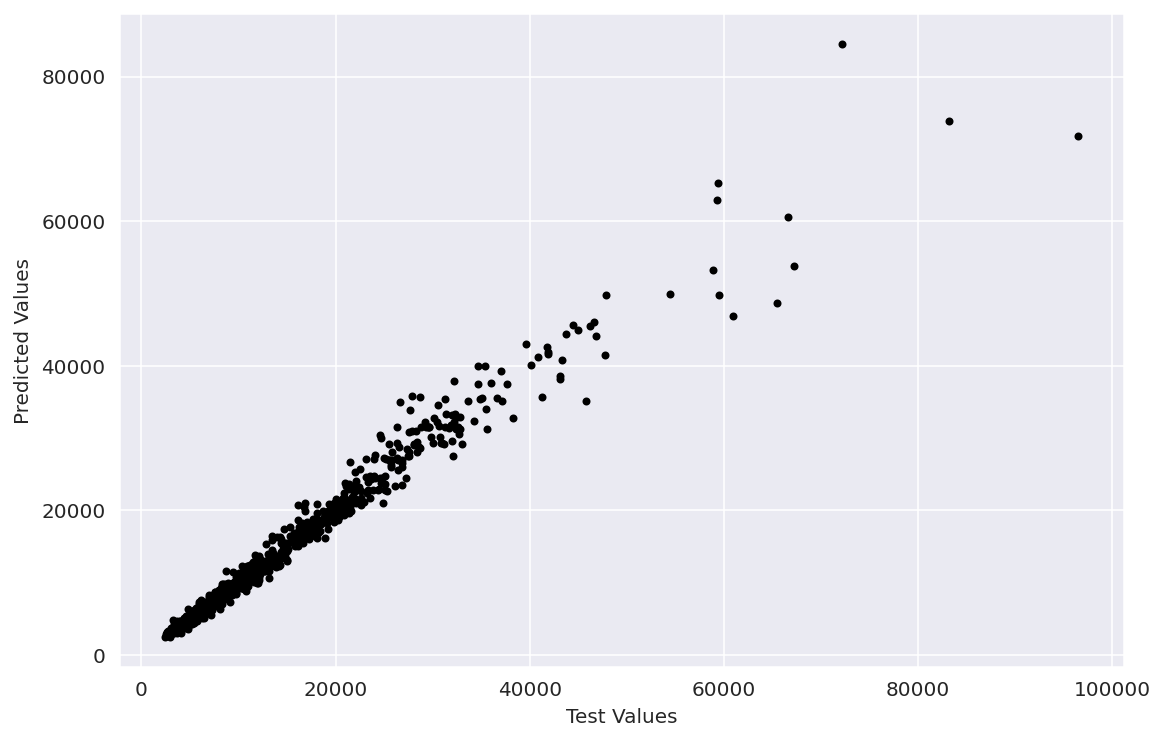

In [85]:
my_regression_results(tpot)

In this instance, TPOT chose an ExtraTreesRegressor. Since the parameters are different for that model, we can't just include the parameters in our results the way we have before. But, we can still track our RMSE and fits.

In [86]:
#ExtraTreesRegressor(LassoLarsCV(input_matrix, normalize=False), bootstrap=True, max_features=0.6000000000000001, min_samples_leaf=1, min_samples_split=6, n_estimators=100)

tpot_best_params = {'learning_rate':'N/A', 'max_depth':'N/A', 'min_child_weight':'N/A', 'n_estimators':100,   'reg_alpha':'N/A', 'reg_lambda':'N/A', 'subsample': 'N/A'}

current = track_results('TPOT-AutoML', tpot_best_params, 1679.61,600, current, True )    

,Approach,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,Fits,RMSE
3,Bayes Search,0.1,10,1,150,5,5,0.334899,175,1660.89
5,TPOT-AutoML,N/A,N/A,N/A,100,N/A,N/A,N/A,600,1679.61
1,Grid Search,0.1,6,1,150,3,3,0.8,960,1700.27
4,TPOT,0.1,8,1,100,3.25,4.0,0.75,400,1719.92
0,Default XGBoost,0.1,3,1,100,0,1,1,1,1829.67
2,Random Search,0.5,8,13,54,4.273531,0.361485,0.982754,125,1870.11


With this seed, Bayes Search with XGBoost still beat the AutoML with TPOT. If you were to run TPOT again with a different random seed or with different settings (more generations/individuals) you'd very likely find a different model.  It often produces nested models where models are applied in sequence. 

Understanding the details of nested models and such isn't important here and we don't recommend blindly using AutoML of any sort, but TPOT can provide good starting points and suggestions for models to investigate further.  We're eager to try other AutoML tools to see how they work.

# Summary

After exploring several different hyperparameter optimization tools, we found that all of them improved the `XGBregressor` model by varying amounts.  Looking just at the hyperparameter optimization of the `xgbr_model` we found that `GridSearchCV` was the most expensive with 960 model fits, but found a very good model.  `RandomSearchCV` and `BayesianOptimizaion` used 125 model fits and 175 model fits, respectively and `BayesianOptimization` identified the model with the lowest MSE on the test data.  However, be careful before concluding that Bayesian Optimization outperforms Random Search.  If you change the random number seeds you'll get different results and Bayesian Optimization will not always be the winner.  However, the consensus is that it works better than Random Search on average.

The last thing we ran was an AutoML experiment with TPOT which used a genetic algorithm to search over many different models and hyperparameter choices.  The model it identified was a pretty crazy nested model that had a slight performance boost over the the optimized `xgboost` model. Due the complexity of that model it might not be the best choice, but it does provide a starting point for other directions to look.  

If you're curious to explore further, there are many AutoML tools being developed.  Here are a couple of interesting ones with which you might experiment:

* **AzureML from Microsoft:** Check out <a href="https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-auto-train-models">this really cool tutorial</a> on using AutoML for choosing a regression model for predicting taxi fares.  The tutorial uses Python and sklearn so it wouldn't be a stretch to follow along.  Moreover, AzureML provides free credits when you sign up.  Just make sure to complete the "Clean Up Resources" section at the end of the tutorial so you don't leave anything running that will use up your free credits!

* **RapidMiner:** We don't have personal experience with this one, but we've only heard good things about it and are eager to check it out.  <a href="https://rapidminer.com/educational-program/">It is free for students.</a> RapidMiner's version of AutoML is a called Auto Model.  You can find a <a href="https://docs.rapidminer.com/latest/studio/auto-model/">tutorial for predicting survival on the Titanic here.</a>

* **Pycaret:** If you're familiar with Caret in R, <a href="https://pycaret.org/">Pycaret</a> should excite you. PyCaret is in development, but new tools are being added all the time. Unfortunately, it doesn't work quite right on CoCalc without downgrading scikit-learn. We encourage you to create your own local environment and play with it on your own, though. There are some good tutorials.

If you try any other AutoML tools, please tell us about it on Piazza.

# Assignment

Optimize a random forest regression model and a XGboost classification model by completing the work in the `Lesson_08_Homework.ipynb` notebook.

# Supplemental Material
While we've provided a balanced dataset for you, an example of a classification problem with imbalanced data is included in the supplemental notebook, Lesson_08_Supplement_Imbalanced_Classification, for those that might like to go further.